# Workflow for the calibration of a individual-specific model

individual specific parameters are estimated by updating the population parameters using a baysian approach

The pypesto ecosystem (https://pypesto.readthedocs.io/en/latest/index.html) is used to perform parameter estimation, profile likelihoods and MCMC sampling

In [8]:
import pypesto
import pypesto.optimize as optimize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.stats import lognorm
import pypesto.sample as sample
import pypesto.visualize as visualize
from tqdm.notebook import tqdm
from pypesto.objective.priors import get_parameter_prior_dict
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter, FormatStrFormatter
from scipy.stats import rv_histogram
from scipy.spatial import distance

#plot specifications
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0
cm = 1/2.54

## Import priors of population-average model 

these files contain the results from the model calibration presented in Fischer-Holzhausen et al. 2023

In [9]:
param_dist = pd.read_pickle('Priors/LogNormDist_Parameter.pkg')
df_optiresults = pd.read_pickle('Priors/OptimizationResult.pkg')
df_pop = pd.read_pickle('Priors/MCMCSampling.pkg')

## Generate individual data

forward simulation with a parameter set from MCMC sampling applied on the population-average model

P - population patameter
params - individual parameter

In [10]:
#this parameter set was used for the example in Fischer-Holzhausen et al. 2023
ind = 147481

#alternative: random sample from the stationary distribution 
#ind=np.random.randint(130000,np.shape(df_pop)[0], size=(1))[0]

P = {"k_syn_FSH": df_pop["FSH_syn"][ind],
    "k_cl_FSH": df_pop["FSH_cl"][ind],
    "k_syn_E2": df_pop["E2_syn"][ind],
    "k_cl_E2": df_pop["E2_cl"][ind],
    "k_syn_LH": df_pop["LH_syn"][ind],
    "k_cl_LH": df_pop["LH_cl"][ind],
    "T_E2_LH": df_pop["T_LH"][ind], 
    "n_E2_LH":  df_pop["n_LH"][ind]}

params = {"sig_growth": df_pop["sig_growth"][ind],
          "sig_midpoint": df_pop["sig_midpoint"][ind],
          "T_FSH_E2": df_pop["T_E2"][ind], 
          "n_FSH_E2": df_pop["n_E2"][ind]}

def dy_dt(t, y):
    
    FSH, E2, LH = y
    
    dFSH = P['k_syn_FSH'] * (1/(1 + np.exp(-params['sig_growth']*(t - params['sig_midpoint'])))) - P['k_cl_FSH']*FSH
    dE2 = P['k_syn_E2'] * ((FSH/params['T_FSH_E2'])**params['n_FSH_E2'])/(1+(FSH/params['T_FSH_E2'])**params['n_FSH_E2']) - P['k_cl_E2']*E2
    dLH = P['k_syn_LH'] * ((E2/P['T_E2_LH'])**P['n_E2_LH'])/(1+(FSH/P['T_E2_LH'])**P['n_E2_LH']) - P['k_cl_LH']*LH

    dydt = [dFSH, dE2, dLH]
    return dydt

#time points with random noise
t_data = [7.5+(np.random.normal(0, 0.15, 1))[0],  8.5+(np.random.normal(0, 0.15, 1))[0],  
          9.5+(np.random.normal(0, 0.15, 1))[0],  10.5+(np.random.normal(0, 0.15, 1))[0], 
          11.5+(np.random.normal(0, 0.15, 1))[0]]
t_span = [5.0, 16.0]

y0 = [0.1,0.1,0.01]

sol = solve_ivp(dy_dt, t_span, y0, t_eval=t_data)

#simulated data with random noise
FSH_data = (sol.y[0]+(np.random.normal(0, 0.1, 5)))
E2_data =(sol.y[1]+(np.random.normal(0, 0.1, 5)))
LH_data =(sol.y[2]+(np.random.normal(0, 0.1, 5)))

## Likelihood function

In [11]:
def Objective(sol_y, sol_t, y_data):

    H = np.zeros(1)
    
    for j in range(np.shape(y_data)[0]):
        for i in range(len(y_data[j])):
            H[0] += (y_data[j][i] - sol_y[j][i])**2

    return H

def CalcObjective(x):

    params["sig_growth"] = x[0]
    params["sig_midpoint"] = x[1]
    params["T_FSH_E2"] = x[2]
    params["n_FSH_E2"] = x[3]

    sol = solve_ivp(dy_dt, t_span, y0, t_eval=t_eval)
    
    return float(Objective(sol.y, sol.t, y_data))

## Define prior distributions Baysian updating

In [12]:
#population parameter -> fixed for the individual fit
P = {"k_syn_FSH": df_optiresults.x[0][0],
    "k_cl_FSH": df_optiresults.x[0][1],
    "k_syn_E2": df_optiresults.x[0][2],
    "k_cl_E2": df_optiresults.x[0][3],
    "k_syn_LH": df_optiresults.x[0][6],
    "k_cl_LH": df_optiresults.x[0][7],
    "T_E2_LH": df_optiresults.x[0][8], 
    "n_E2_LH": df_optiresults.x[0][9]}

#parameters that are updated for the individual fit
params = {"sig_growth": df_optiresults.x[0][10],
          "sig_midpoint": df_optiresults.x[0][11],
          "T_FSH_E2": df_optiresults.x[0][4], 
          "n_FSH_E2": df_optiresults.x[0][5]}

#prior parameter distributions for update
std = [param_dist['sig_growth'][0], 
       param_dist['sig_midpoint'][0], 
       param_dist['T_FSH_E2'][0],
      param_dist['n_FSH_E2'][0]]
mu = [np.log(param_dist['sig_growth'][2]),
      np.log(param_dist['sig_midpoint'][2]),
      np.log(param_dist['T_FSH_E2'][2]),
     np.log(param_dist['n_FSH_E2'][2])]

prior_list = []
for i in range(len(std)):
    prior_list.append(get_parameter_prior_dict(i, "logNormal", [mu[i], std[i]]))

neg_log_prior = pypesto.objective.NegLogParameterPriors(prior_list)
neg_log_likelihood = pypesto.Objective(fun=CalcObjective)
neg_log_posterior = pypesto.objective.AggregatedObjective([neg_log_likelihood, neg_log_prior])

lb = np.array([0.1, 10.0, 1.0, 2.0])
ub = np.array([2.5, 30.0, 10.0, 6.0])
problem = pypesto.Problem(objective=neg_log_posterior,lb=lb,ub=ub,)

## MCMC sampling to update free parameters

In [13]:
sample_num = 700000

params_initial = np.array([params["sig_growth"], 
                           params["sig_midpoint"], 
                           params["T_FSH_E2"],
                           params["n_FSH_E2"]])

#n - number of data points for the updating ('trainings data')
n=3
y0 = [FSH_data[0], E2_data[0], LH_data[0]] 
t_eval = t_data[0:n]
t_init = t_data[0]
t_final = t_data[(n-1)]
t_span = [t_init, t_final]
y_data = [FSH_data[0:n], E2_data[0:n], LH_data[0:n]]


sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(problem, n_samples=sample_num, sampler=sampler, x0=params_initial)
g = sample.geweke_test(result=result)

100%|██████████| 700000/700000 [08:59<00:00, 1298.09it/s]
Elapsed time: 530.1628109999999
Geweke burn-in index: 0


### plot of stationary parameter distribution (individual's parameters)

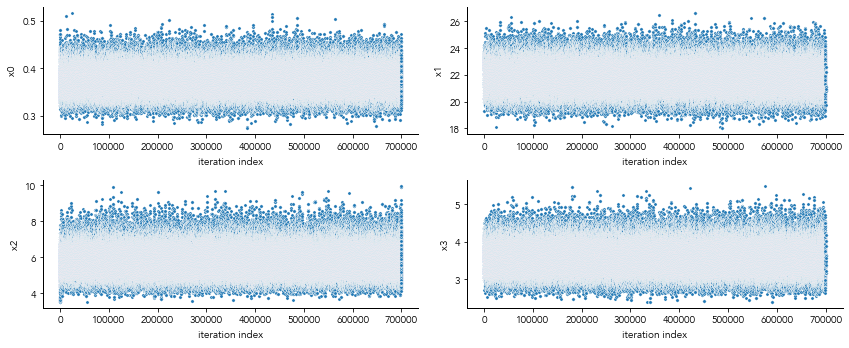

In [14]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

### convert optimisation results in data frame and plot

In [15]:
f_obj = np.empty([0])
sig_growth = np.empty([0]) 
sig_midpoint = np.empty([0])
T_FSH_E2 = np.empty([0])
n_FSH_E2 = np.empty([0]) 

for i in tqdm(range(600000, len(result.sample_result['trace_x'][0]))):
    f_obj = np.append(f_obj, result.sample_result['trace_neglogpost'][0][i])
    sig_growth = np.append(sig_growth, result.sample_result['trace_x'][0][i][0])
    sig_midpoint = np.append(sig_midpoint, result.sample_result['trace_x'][0][i][1])
    T_FSH_E2 = np.append(T_FSH_E2, result.sample_result['trace_x'][0][i][2])
    n_FSH_E2 = np.append(n_FSH_E2, result.sample_result['trace_x'][0][i][3])

d = {'f_obj': f_obj, 
     'sig_growth': sig_growth,
     'sig_midpoint': sig_midpoint, 
     'T_FSH_E2': T_FSH_E2,
     'n_FSH_E2':n_FSH_E2}

MCMC_result = pd.DataFrame(data=d)

  0%|          | 0/100001 [00:00<?, ?it/s]

## Run forward simulations with updated parameter sets

In [16]:
t_init = t_data[0]
t_final = t_data[-1]+0.2
t_eval = np.arange(t_init, t_final, 0.2)
t_span = [t_init, t_final]

y0 = [y_data[0][0], y_data[1][0], y_data[2][0]] 

num_samples = np.shape(MCMC_result)[0]
s = (3,num_samples,len(t_eval))
MCMC_sols = np.zeros(s)

for i in tqdm(range(num_samples)):

    params["T_FSH_E2"] = MCMC_result['T_FSH_E2'][i]
    params["sig_growth"] = MCMC_result['sig_growth'][i]
    params["sig_midpoint"] = MCMC_result['sig_midpoint'][i]
    params["n_FSH_E2"] = MCMC_result['n_FSH_E2'][i]

    sol = solve_ivp(dy_dt, t_span, y0, t_eval=t_eval)
    
    MCMC_sols[0][i] = sol.y[0]
    MCMC_sols[1][i] = sol.y[1]
    MCMC_sols[2][i] = sol.y[2]

  0%|          | 0/100001 [00:00<?, ?it/s]

## Calculate percentiles and plot simulation simulation results for individual-specific model

/var/folders/q_/rcs8q8rn671fsn9yvwb6z2j80000gn/T/ipykernel_90784/3528166245.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].xaxis.set_major_formatter(x_formatter)
/var/folders/q_/rcs8q8rn671fsn9yvwb6z2j80000gn/T/ipykernel_90784/3528166245.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_major_formatter(y_formatter)
/var/folders/q_/rcs8q8rn671fsn9yvwb6z2j80000gn/T/ipykernel_90784/3528166245.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].xaxis.set_major_formatter(x_formatter)
/var/folders/q_/rcs8q8rn671fsn9yvwb6z2j80000gn/T/ipykernel_90784/3528166245.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_major_formatter(y_formatter)
/var/folders/q_/rcs8q8rn671fsn9yvwb6z2j80000gn/T/ipykernel_90784/3528166245.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].xaxis.set_majo

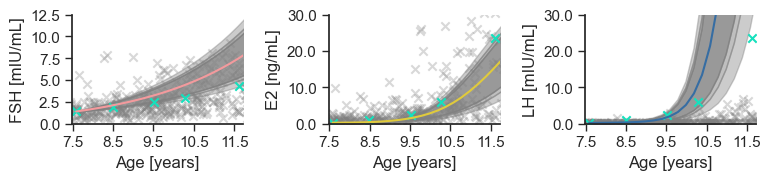

In [261]:
s = (7,len(t_eval))
FSH_perc = np.zeros(s)
E2_perc = np.zeros(s)
LH_perc = np.zeros(s)

FSH_perc = np.percentile(MCMC_sols[0].T, [0.5, 2.5, 5.0, 50.0, 95.0, 97.5, 99.5] , axis=1)
E2_perc = np.percentile(MCMC_sols[1].T, [0.5, 2.5, 5.0, 50.0, 95.0, 97.5, 99.5] , axis=1)
LH_perc = np.percentile(MCMC_sols[2].T, [0.5, 2.5, 5.0, 50.0, 95.0, 97.5, 99.5] , axis=1)

fig, ax = plt.subplots(1,3, figsize=(20*cm, 5*cm), tight_layout=True)
    
ax[0].fill_between(t_eval, FSH_perc[6], FSH_perc[5], color='grey', alpha=0.4, label='99 $\%$ CI')
ax[0].fill_between(t_eval, FSH_perc[5], FSH_perc[4], color='grey', alpha=0.6, label='95 $\%$ CI')
ax[0].fill_between(t_eval, FSH_perc[2], FSH_perc[4], color='grey', alpha=0.8, label='90 $\%$ CI')
ax[0].fill_between(t_eval, FSH_perc[0], FSH_perc[1], color='grey', alpha=0.4, label='_Hidden label')
ax[0].fill_between(t_eval, FSH_perc[1], FSH_perc[2], color='grey', alpha=0.5, label='_Hidden label')
ax[0].scatter(t_data, FSH_data, color='#16E0BD',  marker='x',)
ax[0].plot(t_eval, FSH_perc[3], color='#F39A9D', label='median')
ax[0].set_xlim(t_data[0]-0.1, t_data[-1]+0.11)
x_locator = FixedLocator([7.5, 8.5, 9.5, 10.5, 11.5])
x_formatter = FixedFormatter([7.50, 8.75, 10.00, 11.25])
ax[0].xaxis.set_major_formatter(x_formatter)
ax[0].xaxis.set_major_locator(x_locator)
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0].set_ylim(0.0, 12.5)
y_locator = FixedLocator([0.0, 2.5, 5.0, 7.5, 10.0, 12.5])
y_formatter = FixedFormatter([0.0, 2.5, 5.0, 7.5, 10.0, 12.5])
ax[0].yaxis.set_major_formatter(y_formatter)
ax[0].yaxis.set_major_locator(y_locator)
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set(xlabel='Age [years]', ylabel='FSH [mIU/mL]')

ax[1].fill_between(t_eval, E2_perc[6], E2_perc[5], color='grey', alpha=0.4, label='99 $\%$ CI')
ax[1].fill_between(t_eval, E2_perc[5], E2_perc[4], color='grey', alpha=0.6, label='95 $\%$ CI')
ax[1].fill_between(t_eval, E2_perc[2], E2_perc[4], color='grey', alpha=0.8, label='90 $\%$ CI')
ax[1].fill_between(t_eval, E2_perc[0], E2_perc[1], color='grey', alpha=0.4, label='_Hidden label')
ax[1].fill_between(t_eval, E2_perc[1], E2_perc[2], color='grey', alpha=0.5, label='_Hidden label')
ax[1].scatter(t_data, E2_data, color='#16E0BD',  marker='x',)
ax[1].plot(t_eval, E2_perc[3], color='#E0CA3C', label='median')
ax[1].set_xlim(t_data[0]-0.1, t_data[-1]+0.11)
ax[1].xaxis.set_major_formatter(x_formatter)
ax[1].xaxis.set_major_locator(x_locator)
ax[1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1].set_ylim(0.0, 30.0)
y_locator = FixedLocator([0.0, 10.0, 20.0, 30.0])
y_formatter = FixedFormatter([0.0, 10.0, 20.0, 30.0])
ax[1].yaxis.set_major_formatter(y_formatter)
ax[1].yaxis.set_major_locator(y_locator)
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set(xlabel='Age [years]', ylabel='E2 [ng/mL]')

ax[2].fill_between(t_eval, LH_perc[6], LH_perc[5], color='grey', alpha=0.4, label='99 $\%$ CI')
ax[2].fill_between(t_eval, LH_perc[5], LH_perc[4], color='grey', alpha=0.6, label='95 $\%$ CI')
ax[2].fill_between(t_eval, LH_perc[2], LH_perc[4], color='grey', alpha=0.8, label='90 $\%$ CI')
ax[2].fill_between(t_eval, LH_perc[0], LH_perc[1], color='grey', alpha=0.4, label='_Hidden label')
ax[2].fill_between(t_eval, LH_perc[1], LH_perc[2], color='grey', alpha=0.5, label='_Hidden label')
ax[2].scatter(t_data, E2_data, color='#16E0BD',  marker='x',)
ax[2].plot(t_eval, LH_perc[3], color='#366DA3', label='median')
ax[2].set_xlim(t_data[0]-0.1, t_data[-1]+0.11)
ax[2].xaxis.set_major_formatter(x_formatter)
ax[2].xaxis.set_major_locator(x_locator)
ax[2].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[2].set_ylim(0.0, 30.0)
y_locator = FixedLocator([0.0, 10.0, 20.0, 30.0])
y_formatter = FixedFormatter([0.0, 10.0, 20.0, 30.0])
ax[2].yaxis.set_major_formatter(y_formatter)
ax[2].yaxis.set_major_locator(y_locator)
ax[2].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[2].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[2].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set(xlabel='Age [years]', ylabel='LH [mIU/mL]')

## Compare prior (population) with posterior (individual) marginal parameter distribution 

[Text(0.5, 0, '$n_{FSH}^{E2}$'), Text(0, 0.5, '')]

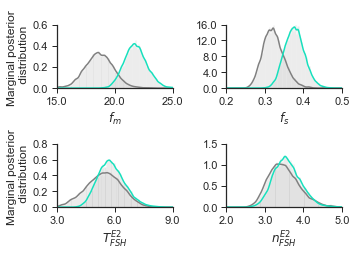

In [17]:
fig, ax = plt.subplots(2,2, figsize=(13*cm, 9*cm), tight_layout=True)

ax[0,0].hist(df_pop['sig_midpoint'], color='grey', alpha=0.2, density=True, bins=100)
df_pop['sig_midpoint'].plot(kind = 'density', color='grey',ax=ax[0,0],)
ax[0,0].hist(MCMC_result['sig_midpoint'], color = 'grey', alpha=0.2, density=True, bins=100)
MCMC_result['sig_midpoint'].plot(kind = 'density', color='#16E0BD',ax=ax[0,0],)
ax[0,0].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0,0].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].set_xlim(15.0, 25.0)
x_locator = FixedLocator([15.0,20.0, 25.0])
x_formatter = FixedFormatter([15.0, 17.5 ,20.0, 22.5, 25.0])
ax[0,0].xaxis.set_major_formatter(x_formatter)
ax[0,0].xaxis.set_major_locator(x_locator)
ax[0,0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0,0].set_ylim(0.0, 0.6)
y_locator = FixedLocator([0.0, 0.2, 0.4, 0.6])
y_formatter = FixedFormatter([0.0, 0.2, 0.4, 0.6])
ax[0,0].yaxis.set_major_formatter(y_formatter)
ax[0,0].yaxis.set_major_locator(y_locator)
ax[0,0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0,0].set(xlabel='$f_m$', ylabel='Marginal posterior \n distribution')

ax[0,1].hist(df_pop['sig_growth'], color='grey', alpha=0.2, density=True, bins=100)
df_pop['sig_growth'].plot(kind = 'density', color='grey',ax=ax[0,1],)
ax[0,1].hist(MCMC_result['sig_growth'], color = 'grey', alpha=0.2, density=True, bins=100)
MCMC_result['sig_growth'].plot(kind = 'density', color='#16E0BD',ax=ax[0,1],)
ax[0,1].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0,1].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].set_xlim(0.2, 0.5)
x_locator = FixedLocator([0.2, 0.3, 0.4, 0.5])
x_formatter = FixedFormatter([0.2, 0.3, 0.4, 0.5])
ax[0,1].xaxis.set_major_formatter(x_formatter)
ax[0,1].xaxis.set_major_locator(x_locator)
ax[0,1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0,1].set_ylim(0.0, 16.0)
y_locator = FixedLocator([0.0, 4.0, 8.0, 12.0, 16.0])
y_formatter = FixedFormatter([0.0, 4.0, 8.0, 12.0, 16.0])
ax[0,1].yaxis.set_major_formatter(y_formatter)
ax[0,1].yaxis.set_major_locator(y_locator)
ax[0,1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[0,1].set(xlabel='$f_s$', ylabel='')

ax[1,0].hist(df_pop['T_E2'], color='grey', alpha=0.2, density=True, bins=100)
df_pop['T_E2'].plot(kind = 'density', color='grey',ax=ax[1,0],)
ax[1,0].hist(MCMC_result['T_FSH_E2'], color = 'grey', alpha=0.2, density=True, bins=100)
MCMC_result['T_FSH_E2'].plot(kind = 'density', color='#16E0BD',ax=ax[1,0],)
ax[1,0].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1,0].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].set_xlim(3.0, 9.0)
x_locator = FixedLocator([3.0, 6.0, 9.0])
x_formatter = FixedFormatter([3.0, 6.0, 9.0])
ax[1,0].xaxis.set_major_formatter(x_formatter)
ax[1,0].xaxis.set_major_locator(x_locator)
ax[1,0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1,0].set_ylim(0.0, 0.8)
y_locator = FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8])
y_formatter = FixedFormatter([0.0, 0.2, 0.4, 0.6, 0.8])
ax[1,0].yaxis.set_major_formatter(y_formatter)
ax[1,0].yaxis.set_major_locator(y_locator)
ax[1,0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1,0].set(xlabel='$T_{FSH}^{E2}$', ylabel='Marginal posterior \n distribution')

ax[1,1].hist(df_pop['n_E2'], color='grey', alpha=0.2, density=True, bins=100)
df_pop['n_E2'].plot(kind = 'density', color='grey',ax=ax[1,1],)
ax[1,1].hist(MCMC_result['n_FSH_E2'], color = 'grey', alpha=0.2, density=True, bins=100)
MCMC_result['n_FSH_E2'].plot(kind = 'density', color='#16E0BD',ax=ax[1,1],)
ax[1,1].xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1,1].yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].set_xlim(2.0, 5.0)
x_locator = FixedLocator([2.0, 3.0, 4.0, 5.0])
x_formatter = FixedFormatter([2.0, 3.0, 4.0, 5.0])
ax[1,1].xaxis.set_major_formatter(x_formatter)
ax[1,1].xaxis.set_major_locator(x_locator)
ax[1,1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1,1].set_ylim(0.0, 1.5)
y_locator = FixedLocator([0.0, 0.5, 1.0, 1.5])
y_formatter = FixedFormatter([0.0, 0.5, 1.0, 1.5])
ax[1,1].yaxis.set_major_formatter(y_formatter)
ax[1,1].yaxis.set_major_locator(y_locator)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax[1,1].set(xlabel='$n_{FSH}^{E2}$', ylabel='')

## Calculate Jenson-Shannon divergance to quantify the difference between the two marginal parameter distributions for the updated parameters

Text(0, 0.5, 'Jenson-Shanon- \n Divergance')

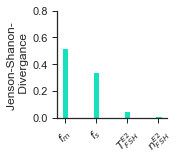

In [18]:
def JSD(p,q):

    # Construct empirical PDF with these two samples
    hist1 = np.histogram(p, bins=100)
    hist1_dist = rv_histogram(hist1)
    hist2 = np.histogram(q, bins=100)
    hist2_dist = rv_histogram(hist2)

    X = np.linspace(0, 30, 1000)
    Y1 = hist1_dist.pdf(X)
    Y2 = hist2_dist.pdf(X)
    
    return(distance.jensenshannon(Y1,Y2)**2)

num_params = 4
num_ind = 1 

s = np.zeros((num_params,num_ind))

s[0] = JSD(df_pop['sig_midpoint'], MCMC_result['sig_midpoint'])
s[1] = JSD(df_pop['sig_growth'], MCMC_result['sig_growth'])
s[2] = JSD(df_pop['T_E2'], MCMC_result['T_FSH_E2'])
s[3]= JSD(df_pop['n_E2'], MCMC_result['n_FSH_E2'])


X = ['$f_m$','$f_s$','$T_{FSH}^{E2}$','$n_{FSH}^{E2}$']

fig, ax = plt.subplots(figsize=(5*cm, 5*cm))

X_axis = np.arange(len(X))
  
plt.bar(X_axis, s.T[0], 0.2, label = 'Individual 1', color='#16E0BD')

ax.xaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(0.0, 0.8)
y_locator = FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8])
y_formatter = FixedFormatter([0.0, 0.2, 0.4, 0.6, 0.8])
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.xticks(rotation=45)

plt.xticks(X_axis, X)
plt.ylabel("Jenson-Shanon- \n Divergance")